In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [4]:
test_data = datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)


In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [9]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [10]:
x = X_train.view(1,1,28,28)   # ----> convert to a single 4D batch of 1 image

In [11]:
x = F.relu(conv1(x))


In [12]:
x.shape

torch.Size([1, 6, 26, 26])

In [13]:
x = F.max_pool2d(x, 2, 2)

In [14]:
x.shape

torch.Size([1, 6, 13, 13])

In [15]:
x = F.relu(conv2(x))

In [16]:
x.shape

torch.Size([1, 16, 11, 11])

In [17]:
x = F.max_pool2d(x, 2, 2)

In [18]:
x.shape

torch.Size([1, 16, 5, 5])

In [19]:
# This is the formula for the entire convolution operation above
(((28 - 2) // 2) - 2) // 2

5

In [20]:
x.shape

torch.Size([1, 16, 5, 5])

In [21]:
x.view(-1, 16*5*5).shape

torch.Size([1, 400])

In [22]:
class ConvolutionalNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, 16*5*5)

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)

In [23]:
torch.manual_seed(42)

model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [24]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
import time

start_time = time.time()

# VARIABLES (TRACKERS)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# FOR LOOP EPOCHS
for i in range(epochs):

    trn_corr = 0
    tst_corr = 0

    # TRAIN
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(X_train) # no need to flatten
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()   # True 1 / False 0 sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%600 == 0:
            print(f"Epoch: {i} Batch: {b} Loss: {loss.item()}")

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # TEST
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

current_time = time.time()

total = current_time - start_time
print(f"Training took {total / 60} minutes")

Epoch: 0 Batch: 600 Loss: 0.040556278079748154
Epoch: 0 Batch: 1200 Loss: 0.0825348049402237
Epoch: 0 Batch: 1800 Loss: 0.3642270565032959
Epoch: 0 Batch: 2400 Loss: 0.0185597725212574
Epoch: 0 Batch: 3000 Loss: 0.00640881946310401
Epoch: 0 Batch: 3600 Loss: 0.0015721835661679506
Epoch: 0 Batch: 4200 Loss: 0.6425320506095886
Epoch: 0 Batch: 4800 Loss: 0.024504834786057472
Epoch: 0 Batch: 5400 Loss: 0.012283298186957836
Epoch: 0 Batch: 6000 Loss: 0.04107318073511124
Epoch: 1 Batch: 600 Loss: 0.009434794075787067
Epoch: 1 Batch: 1200 Loss: 0.03555027395486832
Epoch: 1 Batch: 1800 Loss: 0.0014050512108951807
Epoch: 1 Batch: 2400 Loss: 0.023782700300216675
Epoch: 1 Batch: 3000 Loss: 0.20474597811698914
Epoch: 1 Batch: 3600 Loss: 0.001031014253385365
Epoch: 1 Batch: 4200 Loss: 0.0002251201367471367
Epoch: 1 Batch: 4800 Loss: 0.0006508632795885205
Epoch: 1 Batch: 5400 Loss: 0.001225375453941524
Epoch: 1 Batch: 6000 Loss: 0.03623572364449501
Epoch: 2 Batch: 600 Loss: 0.0010293092345818877
Epo

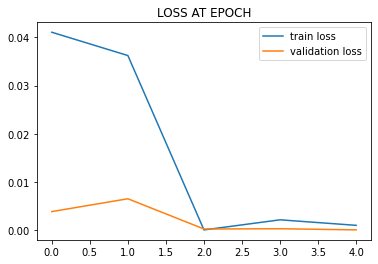

In [29]:
with torch.no_grad():
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='validation loss')
    plt.title('LOSS AT EPOCH')
    plt.legend()

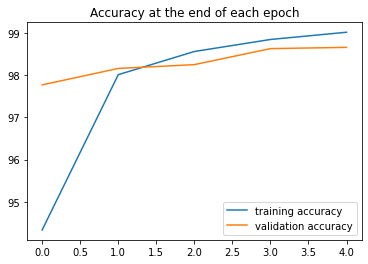

In [30]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [31]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [32]:
with torch.no_grad():
    correct = 0

    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [35]:
correct.item() / len(test_data)

0.9866

In [36]:
# CONFUSION MATRIX

# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f"{x:4}"))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 971    0    0    0    0    2    4    0    2    1]
 [   0 1131    2    0    0    0    2    2    0    0]
 [   2    0 1020    1    1    0    1    4    2    0]
 [   0    2    0 1003    0    8    0    0    1    3]
 [   0    2    1    0  977    0    1    5    3   18]
 [   0    0    0    3    0  862    0    0    1    2]
 [   5    0    0    0    2    6  949    0    2    0]
 [   1    0    7    1    0    1    0 1012    0    3]
 [   1    0    2    2    0    4    1    1  961    2]
 [   0    0    0    0    2    9    0    4    2  980]]


In [39]:
test_data[2019][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

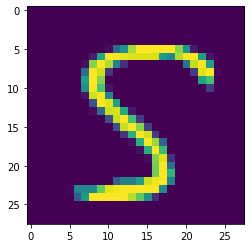

In [43]:
plt.imshow(test_data[333][0].reshape(28,28))

In [44]:
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[333][0].view(1,1,28,28))

In [45]:
new_prediction.argmax()

tensor(5)